In [1]:
# Opciones de decodificación para otros parámetros
layer_type_options = {
    0: 'Conv2D',
    1: 'BatchNorm',
    2: 'MaxPooling',
    3: 'Dropout',
    4: 'Dense',
    5: 'Flatten',
    6: 'DepthwiseConv2D',
    7: 'DontCare',
    8: 'Repetition'
}
stride_options = {0: 1, 1: 2}
dropout_options = {0: 0.2, 1: 0.3, 2: 0.4, 3: 0.5}
activation_options = {0: 'relu', 1: 'leaky_relu', 2: 'sigmoid', 3: 'tanh'}

# Función para codificar los parámetros de la capa
def encode_layer_params(layer_type_idx, param1=0, param2=0, param3=0):
    """
    Codifica una capa en una lista en función del tipo de capa y sus parámetros.

    layer_type_idx : int : índice del tipo de capa según layer_type_options.
    param1         : int/float : filtros, neuronas, capas de repetición, etc.
    param2         : int : stride, número de repeticiones, etc.
    param3         : int : índice de activación o tasa de dropout.
    """
    return [layer_type_idx, param1, param2, param3]

# Función para decodificar los parámetros de la capa
def decode_layer_params(encoded_params):
    """
    Decodifica una capa desde su representación codificada en parámetros interpretables.

    encoded_params : list : [tipo de capa, param1, param2, param3].
    """
    layer_type_idx = encoded_params[0]
    layer_type = layer_type_options.get(layer_type_idx, 'DontCare')

    # Decodificar en función del tipo de capa
    if layer_type in ['Conv2D', 'DepthwiseConv2D']:
        filters = max(4, min(encoded_params[1], 32))  # Limitar filtros entre 4 y 32
        strides = stride_options.get(encoded_params[2], 1)
        activation = activation_options.get(encoded_params[3], 'relu')
        return {
            'type': layer_type,
            'filters': filters,
            'strides': strides,
            'activation': activation
        }
    elif layer_type == 'BatchNorm':
        return {'type': 'BatchNorm'}
    elif layer_type == 'MaxPooling':
        strides = stride_options.get(encoded_params[1], 1)
        return {'type': 'MaxPooling', 'strides': strides}
    elif layer_type == 'Dropout':
        rate = dropout_options.get(encoded_params[1], 0.2)
        return {'type': 'Dropout', 'rate': rate}
    elif layer_type == 'Dense':
        units = max(1, min(encoded_params[1], 512))  # Limitar unidades entre 1 y 512
        activation = activation_options.get(encoded_params[2], 'relu')
        return {'type': 'Dense', 'units': units, 'activation': activation}
    elif layer_type == 'Flatten':
        return {'type': 'Flatten'}
    elif layer_type == 'Repetition':
        return {
            'type': 'Repetition',
            'repetition_layers': int(encoded_params[1]),
            'repetition_count': int(encoded_params[2])
        }
    elif layer_type == 'DontCare':
        return {'type': "DontCare"}

    return None

# Ejemplos de codificación y decodificación
encoded_conv2d = encode_layer_params(0, 16, 0, 0)  # Conv2D con 16 filtros, stride 1 y activación ReLU
decoded_conv2d = decode_layer_params(encoded_conv2d)
print(f"\nCodificación real de Conv2D: {encoded_conv2d}")
print(f"Decodificación Conv2D: {decoded_conv2d}")

encoded_dropout = encode_layer_params(3, 1)  # Dropout con tasa de 0.3
decoded_dropout = decode_layer_params(encoded_dropout)
print(f"\nCodificación real de Dropout: {encoded_dropout}")
print(f"Decodificación Dropout: {decoded_dropout}")

encoded_dense = encode_layer_params(4, 128, 0)  # Dense con 128 neuronas y activación ReLU
decoded_dense = decode_layer_params(encoded_dense)
print(f"\nCodificación real de Dense: {encoded_dense}")
print(f"Decodificación Dense: {decoded_dense}")

encoded_repetition = encode_layer_params(8, 3, 5)  # Repetition para repetir las últimas 3 capas 5 veces
decoded_repetition = decode_layer_params(encoded_repetition)
print(f"\nCodificación real de Repetition: {encoded_repetition}")
print(f"Decodificación Repetition: {decoded_repetition}")



Codificación real de Conv2D: [0, 16, 0, 0]
Decodificación Conv2D: {'type': 'Conv2D', 'filters': 16, 'strides': 1, 'activation': 'relu'}

Codificación real de Dropout: [3, 1, 0, 0]
Decodificación Dropout: {'type': 'Dropout', 'rate': 0.3}

Codificación real de Dense: [4, 128, 0, 0]
Decodificación Dense: {'type': 'Dense', 'units': 128, 'activation': 'relu'}

Codificación real de Repetition: [8, 3, 5, 0]
Decodificación Repetition: {'type': 'Repetition', 'repetition_layers': 3, 'repetition_count': 5}


In [2]:
def int_to_real_dom(num, domain):
  min_i, max_i = domain
  r = (num - min_i) / (max_i - min_i)
  return r

def real_to_int_dom(num, domain):
  min_i, max_i = domain
  value = min_i + num * (max_i - min_i)
  if isinstance(min_i, int) and isinstance(max_i, int):
      value = int(round(value))
  return value

def convert_individual(ind, to_real=True):
    real_rep = []
    N = max(layer_type_options.keys())
    for i in range(0, len(ind), 4):
        layer_type_idx = ind[i]
        domain_layer_type = [0, N]
        if to_real:
            real_rep.append(int_to_real_dom(layer_type_idx, domain_layer_type))
            layer_type = layer_type_options.get(layer_type_idx, 'DontCare')
        else:
            real_rep.append(real_to_int_dom(layer_type_idx, domain_layer_type))
            layer_type = layer_type_options.get(real_rep[i], 'DontCare')

        # Decode based on layer type
        if layer_type in ['Conv2D', 'DepthwiseConv2D']:
            if to_real:
                real_rep.append(int_to_real_dom(ind[i + 1], [4, 32]))
                real_rep.append(int_to_real_dom(ind[i + 2], [0, 1]))
                real_rep.append(int_to_real_dom(ind[i + 3], [0, 3]))
            else:
                real_rep.append(real_to_int_dom(ind[i + 1], [4, 32]))
                real_rep.append(real_to_int_dom(ind[i + 2], [0, 1]))
                real_rep.append(real_to_int_dom(ind[i + 3], [0, 3]))
        elif layer_type == 'BatchNorm':
            real_rep.extend([0, 0, 0])
        elif layer_type == 'MaxPooling':
            if to_real:
                real_rep.append(int_to_real_dom(ind[i + 1], [0, 1]))
            else:
                real_rep.append(real_to_int_dom(ind[i + 1], [0, 1]))
            real_rep.extend([0, 0])
        elif layer_type == 'Dropout':
            if to_real:
                real_rep.append(int_to_real_dom(ind[i + 1], [0, 3]))
            else:
                real_rep.append(real_to_int_dom(ind[i + 1], [0, 3]))
            real_rep.extend([0, 0])
        elif layer_type == 'Dense':
            if to_real:
                real_rep.append(int_to_real_dom(ind[i + 1], [1, 512]))
                real_rep.append(int_to_real_dom(ind[i + 2], [0, 3]))
            else:
                real_rep.append(real_to_int_dom(ind[i + 1], [1, 512]))
                real_rep.append(real_to_int_dom(ind[i + 2], [0, 3]))
            real_rep.append(0)
        elif layer_type == 'Flatten':
            real_rep.extend([0, 0, 0])
        elif layer_type == 'Repetition':
            if to_real:
                real_rep.append(int_to_real_dom(ind[i + 1], [1, 4]))
                real_rep.append(int_to_real_dom(ind[i + 2], [1, 32]))
            else:
                real_rep.append(real_to_int_dom(ind[i + 1], [1, 4]))
                real_rep.append(real_to_int_dom(ind[i + 2], [1, 32]))
            real_rep.append(0)
        elif layer_type == 'DontCare':
            real_rep.extend([0, 0, 0])
    return real_rep

In [3]:
x = [1, 0, 0, 0, 6, 5, 0, 2, 8, 1, 1, 0, 4, 17, 3, 0, 4, 22, 0, 0, 7, 0, 0, 0, 0, 11, 1, 3, 3, 0, 0, 0, 3, 1, 0, 0, 4, 63, 3, 0, 1, 0, 0, 0, 5, 0, 0, 0]
print(x)
y = convert_individual(x)
print(y)
z = convert_individual(y, to_real=False)
print(z)

[1, 0, 0, 0, 6, 5, 0, 2, 8, 1, 1, 0, 4, 17, 3, 0, 4, 22, 0, 0, 7, 0, 0, 0, 0, 11, 1, 3, 3, 0, 0, 0, 3, 1, 0, 0, 4, 63, 3, 0, 1, 0, 0, 0, 5, 0, 0, 0]
[0.125, 0, 0, 0, 0.75, 0.03571428571428571, 0.0, 0.6666666666666666, 1.0, 0.0, 0.0, 0, 0.5, 0.03131115459882583, 1.0, 0, 0.5, 0.0410958904109589, 0.0, 0, 0.875, 0, 0, 0, 0.0, 0.25, 1.0, 1.0, 0.375, 0.0, 0, 0, 0.375, 0.3333333333333333, 0, 0, 0.5, 0.12133072407045009, 1.0, 0, 0.125, 0, 0, 0, 0.625, 0, 0, 0]
[1, 0, 0, 0, 6, 5, 0, 2, 8, 1, 1, 0, 4, 17, 3, 0, 4, 22, 0, 0, 7, 0, 0, 0, 0, 11, 1, 3, 3, 0, 0, 0, 3, 1, 0, 0, 4, 63, 3, 0, 1, 0, 0, 0, 5, 0, 0, 0]


In [4]:
import tensorflow as tf

# Clase para capas neutrales 'DontCare'
class DontCareLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(DontCareLayer, self).__init__()

    def call(self, inputs):
        return inputs

In [5]:
def encode_model_architecture(model_dict, max_alleles=48):
    """
    Codifica la arquitectura del modelo en una lista de valores con un máximo de `max_alleles`.
    Cada capa se codifica en función de sus parámetros.
    """
    encoded_layers = []
    total_alleles = 0

    for layer in model_dict['layers']:
        if layer['type'] == 'Repetition':  # Codificar capa de repetición
            encoded_layer = encode_layer_params(
                layer_type_idx=8,  # índice para 'Repetition'
                param1=layer.get('repetition_layers', 0),
                param2=layer.get('repetition_count', 1)
            )
        else:
            layer_type_idx = next(
                key for key, value in layer_type_options.items() if value == layer['type']
            )

            # Codificar parámetros específicos de cada tipo de capa
            if layer['type'] in ['Conv2D', 'DepthwiseConv2D']:
                # Limitar filtros dentro del rango [4, 32]
                param1 = max(4, min(layer.get('filters', 8), 32))
                param2 = next((key for key, value in stride_options.items() if value == layer.get('strides', 1.0)), 0)
                param3 = next((key for key, value in activation_options.items() if value == layer.get('activation', 'relu')), 0)
                encoded_layer = [layer_type_idx, param1, param2, param3]

            elif layer['type'] == 'Dense':
                # Limitar neuronas dentro del rango [1, 512]
                param1 = max(1, min(layer.get('units', 1), 512))
                param2 = next((key for key, value in activation_options.items() if value == layer.get('activation', 'relu')), 0)
                encoded_layer = [layer_type_idx, param1, param2, 0]

            elif layer['type'] == 'MaxPooling':
                param1 = next((key for key, value in stride_options.items() if value == layer.get('strides', 1.0)), 0)
                encoded_layer = [layer_type_idx, param1, 0, 0]

            elif layer['type'] == 'Dropout':
                param1 = next((key for key, value in dropout_options.items() if value == layer.get('rate', 0.2)), 0)
                encoded_layer = [layer_type_idx, param1, 0, 0]

            elif layer['type'] == 'BatchNorm':
                encoded_layer = [layer_type_idx, 0, 0, 0]

            elif layer['type'] == 'Flatten':
                encoded_layer = [layer_type_idx, 0, 0, 0]

            elif layer['type'] == 'DontCare':
                encoded_layer = [layer_type_idx, 0, 0, 0]

        # Añadir la codificación de la capa a la lista de alelos
        encoded_layers.extend(encoded_layer)
        total_alleles += len(encoded_layer)

    # Rellenar con 'DontCare' si el total de alelos es menor que `max_alleles`
    while total_alleles < max_alleles:
        dont_care_encoding = encode_layer_params(7)  # índice de 'DontCare'
        encoded_layers.extend(dont_care_encoding)
        total_alleles += len(dont_care_encoding)

    # Recortar si excede `max_alleles`
    final_encoding = encoded_layers[:max_alleles]
    #print(f"Final Encoded Model: {final_encoding}")

    return final_encoding


In [6]:
import random

def fixArch(encoded_model, verbose=False):
    """
    Corrige la arquitectura codificada del modelo, asegurando que:
    - Se evite la presencia de capas incompatibles después de una capa Flatten.
    - En caso de una capa de Repetition, se ajuste el alcance de repetición si no hay suficientes capas anteriores.

    Parameters:
        encoded_model (list): Lista codificada de la arquitectura del modelo.
        verbose (bool): Si es True, muestra las correcciones realizadas.

    Returns:
        list: Lista con la arquitectura corregida, truncada a un máximo de 48 alelos.
    """

    fixed_layers = []  # Lista que almacenará la arquitectura corregida
    input_is_flattened = False  # Indicador para saber si ya hay una capa Flatten en el modelo
    index = 0  # Índice para recorrer el modelo codificado

    # Procesar cada capa en el modelo sin forzar la primera capa a ser específica
    while index < len(encoded_model) and len(fixed_layers) < 48:
        layer_type = int(encoded_model[index])  # Obtener el tipo de capa actual

        # Procesar la capa de Repetition
        if layer_type == 8:
            repetition_layers = int(encoded_model[index + 1])  # Número de capas a repetir
            repetition_count = min(max(int(encoded_model[index + 2]), 0), 32)  # Cantidad de repeticiones

            # Verificar si hay suficientes capas para la repetición solicitada
            actual_layers_to_repeat = min(repetition_layers, len(fixed_layers) // 4)

            if actual_layers_to_repeat != repetition_layers:
                if verbose:
                    print(f"Ajustando alcance de repetición de {repetition_layers} a {actual_layers_to_repeat} debido a falta de capas.")
                repetition_layers = actual_layers_to_repeat

            # Añadir la capa de repetición sin modificar su estructura
            fixed_layers.extend([layer_type, repetition_layers, repetition_count, 0])
            index += 4
            continue

        # Procesar cada tipo de capa normal con sus restricciones
        if layer_type == 0:  # Conv2D
            if input_is_flattened:
                fixed_layers.extend([7, 0, 0, 0])  # DontCare
            else:
                # Limitar el número de filtros entre 4 y 32
                filters = min(max(int(encoded_model[index + 1]), 4), 32)
                stride_idx = min(max(int(encoded_model[index + 2]), 0), 1)
                activation_idx = min(max(int(encoded_model[index + 3]), 0), 3)
                fixed_layers.extend([layer_type, filters, stride_idx, activation_idx])

        elif layer_type == 6:  # DepthwiseConv2D
            if input_is_flattened:
                fixed_layers.extend([7, 0, 0, 0])  # DontCare
            else:
                # Limitar el número de filtros entre 4 y 32
                filters = min(max(int(encoded_model[index + 1]), 4), 32)
                stride_idx = min(max(int(encoded_model[index + 2]), 0), 1)
                activation_idx = min(max(int(encoded_model[index + 3]), 0), 3)
                fixed_layers.extend([layer_type, filters, stride_idx, activation_idx])

        elif layer_type == 2:  # MaxPooling
            if input_is_flattened:
                fixed_layers.extend([7, 0, 0, 0])  # DontCare
            else:
                stride_idx = min(max(int(encoded_model[index + 1]), 0), 1)
                fixed_layers.extend([layer_type, stride_idx, 0, 0])

        elif layer_type == 3:  # Dropout
            rate_idx = min(max(int(encoded_model[index + 1]), 0), 3)
            fixed_layers.extend([layer_type, rate_idx, 0, 0])

        elif layer_type == 4:  # Dense
            # Limitar el número de neuronas entre 1 y 512
            neurons = min(max(int(encoded_model[index + 1]), 1), 512)
            activation_idx = min(max(int(encoded_model[index + 2]), 0), 3)
            fixed_layers.extend([layer_type, neurons, activation_idx, 0])

        elif layer_type == 1:  # BatchNorm
            fixed_layers.extend([layer_type, 0, 0, 0])

        elif layer_type == 5:  # Flatten
            if len(fixed_layers) < 16:
                fixed_layers.extend([7, 0, 0, 0])  # DontCare
            elif input_is_flattened:
                fixed_layers.extend([7, 0, 0, 0])  # DontCare
            else:
                fixed_layers.extend([layer_type, 0, 0, 0])
                input_is_flattened = True  # Marcar que ya hay un Flatten

        elif layer_type == 7:  # DontCare
            fixed_layers.extend([layer_type, 0, 0, 0])

        else: # DontCare
          fixed_layers.extend([7, 0, 0, 0])

        index += 4  # Avanzar al siguiente grupo de parámetros

    return fixed_layers[:48]  # Limitar a 48 alelos


In [7]:
def decode_model_architecture(encoded_model):
    """
    Decodifica la arquitectura del modelo a partir de la lista codificada de valores (índices),
    aplicando las reglas de repetición y asegurando la inclusión de una capa convolucional inicial.
    """
    model_dict = {'layers': [{'type': 'Conv2D', 'filters': 32, 'strides': 1, 'activation': 'relu'}]}  # Inserta Conv2D inicial
    index = 0

    while index < len(encoded_model):
        layer_type = int(encoded_model[index])
        param1 = encoded_model[index + 1]
        param2 = encoded_model[index + 2]
        param3 = encoded_model[index + 3]

        if layer_type == 8:  # Capa de Repetition
            repetition_layers = int(param1)
            repetition_count = int(param2)
            # Selecciona solo el grupo válido de capas para la repetición
            layers_to_repeat = select_group_for_repetition(model_dict['layers'], repetition_layers)

            if len(layers_to_repeat) > 0:
                for _ in range(repetition_count):
                    model_dict['layers'].extend(layers_to_repeat)

        else:
            decoded_layer = {}

            if layer_type == 0:  # Conv2D
                decoded_layer = {
                    'type': 'Conv2D',
                    'filters': max(4, min(param1, 32)),  # Limita `filters` entre 4 y 32
                    'strides': stride_options.get(param2, 1),
                    'activation': activation_options.get(param3, 'relu')
                }
            elif layer_type == 6:  # DepthwiseConv2D
                decoded_layer = {
                    'type': 'DepthwiseConv2D',
                    'filters': max(4, min(param1, 32)),  # Limita `filters` entre 4 y 32
                    'strides': stride_options.get(param2, 1),
                    'activation': activation_options.get(param3, 'relu')
                }
            elif layer_type == 2:  # MaxPooling
                decoded_layer = {
                    'type': 'MaxPooling',
                    'strides': stride_options.get(param1, 1)
                }
            elif layer_type == 3:  # Dropout
                decoded_layer = {
                    'type': 'Dropout',
                    'rate': dropout_options.get(param1, 0.2)
                }
            elif layer_type == 4:  # Dense
                decoded_layer = {
                    'type': 'Dense',
                    'units': max(1, min(param1, 512)),  # Limita `units` entre 1 y 512
                    'activation': activation_options.get(param2, 'relu')
                }
            elif layer_type == 1:  # BatchNorm
                decoded_layer = {'type': 'BatchNorm'}
            elif layer_type == 5:  # Flatten
                decoded_layer = {'type': 'Flatten'}
            elif layer_type == 7:  # DontCare
                decoded_layer = {'type': 'DontCare'}

            model_dict['layers'].append(decoded_layer)

        index += 4

    # Asegura que haya una capa Flatten antes de la capa Dense final, si no ya existe una Flatten
    if model_dict['layers'][-1]['type'] != 'Flatten':
        model_dict['layers'].append({'type': 'Flatten'})

    # Añade la capa Dense final obligatoria
    model_dict['layers'].append({'type': 'Dense', 'units': 1, 'activation': 'sigmoid'})

    return model_dict

def select_group_for_repetition(layers, repetition_layers):
    """
    Selecciona el primer grupo válido para repetición en función de las reglas de compatibilidad.

    Parameters:
        layers (list): Lista de capas ya procesadas, donde cada capa es un diccionario.
        repetition_layers (int): Número de capas hacia atrás para considerar en la repetición.

    Returns:
        list: Lista de capas compatibles para repetición.
    """
    valid_layers = []
    group_type = None

    # Retrocede desde el final de `layers` para encontrar el grupo válido
    for layer in reversed(layers[-repetition_layers:]):
        if group_type is None:
            # Determina el tipo de grupo
            if layer['type'] in ['Flatten', 'Dense']:
                group_type = 'dense'
                valid_layers.insert(0, layer)
            elif layer['type'] in ['Conv2D', 'DepthwiseConv2D', 'MaxPooling']:
                group_type = 'convolutional'
                valid_layers.insert(0, layer)
            elif layer['type'] in ['BatchNorm', 'DontCare']:  # BatchNorm y DontCare son compatibles con ambos grupos
                valid_layers.insert(0, layer)
        else:
            # Agrega solo capas compatibles con el grupo seleccionado
            if group_type == 'dense' and layer['type'] in ['Flatten', 'Dense', 'BatchNorm', 'DontCare']:
                valid_layers.insert(0, layer)
            elif group_type == 'convolutional' and layer['type'] in ['Conv2D', 'DepthwiseConv2D', 'MaxPooling', 'BatchNorm', 'DontCare']:
                valid_layers.insert(0, layer)

    return valid_layers


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization, DepthwiseConv2D



def build_tf_model_from_dict(model_dict, input_shape=(28, 28, 3)):
    """
    Construye un modelo de TensorFlow a partir de un diccionario JSON expandido.
    """
    print("\nConstruyendo el modelo en TensorFlow desde el JSON expandido...")
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=input_shape))

    for layer in model_dict['layers']:
        if layer['type'] == 'Conv2D':
            model.add(Conv2D(filters=layer['filters'], kernel_size=(3, 3), strides=int(layer['strides']), padding='same', activation=layer['activation']))

        elif layer['type'] == 'DepthwiseConv2D':
            model.add(DepthwiseConv2D(kernel_size=(3, 3), strides=int(layer['strides']), padding='same', activation=layer['activation']))

        elif layer['type'] == 'BatchNorm':
            model.add(BatchNormalization())

        elif layer['type'] == 'MaxPooling':
            model.add(MaxPooling2D(pool_size=(2, 2), strides=int(layer['strides']), padding='same'))

        elif layer['type'] == 'Flatten':
            model.add(Flatten())

        elif layer['type'] == 'Dense':
            model.add(Dense(units=int(layer['units']), activation=layer['activation']))

        elif layer['type'] == 'Dropout':
            model.add(Dropout(rate=layer['rate']))

        elif layer['type'] == 'DontCare':
            model.add(DontCareLayer())

    return model


In [9]:
import random
import tensorflow as tf

def generate_random_architecture():
    num_layers = 12
    layers = []

    for _ in range(num_layers):
        layer_type = random.choice([
            'Conv2D', 'DepthwiseConv2D', 'BatchNorm', 'MaxPooling', 'Dropout',
            'Dense', 'Flatten', 'DontCare', 'Repetition'
        ])
        layers.append(generate_layer(layer_type))
    return {"layers": layers}

def generate_layer(layer_type):
    if layer_type == 'Conv2D':
        return {
            "type": "Conv2D",
            "filters": random.randint(4, 16),  # Rango reducido para filtros
            "strides": random.choice([1, 2]),
            "activation": random.choice(["relu", "leaky_relu", "sigmoid", "tanh"])
        }
    elif layer_type == 'DepthwiseConv2D':
        return {
            "type": "DepthwiseConv2D",
            "filters": random.randint(4, 16),  # Rango reducido para filtros
            "strides": random.choice([1, 2]),
            "activation": random.choice(["relu", "leaky_relu", "sigmoid", "tanh"])
        }
    elif layer_type == 'BatchNorm':
        return {"type": "BatchNorm"}
    elif layer_type == 'MaxPooling':
        return {
            "type": "MaxPooling",
            "strides": random.choice([1, 2])
        }
    elif layer_type == 'Dropout':
        return {
            "type": "Dropout",
            "rate": random.choice([0.2, 0.3, 0.4, 0.5])
        }
    elif layer_type == 'Dense':
        return {
            "type": "Dense",
            "units": random.randint(1, 128),  # Rango reducido para unidades
            "activation": random.choice(["relu", "leaky_relu", "sigmoid", "tanh"])
        }
    elif layer_type == 'Flatten':
        return {"type": "Flatten"}
    elif layer_type == 'DontCare':
        return {"type": "DontCare"}
    elif layer_type == 'Repetition':
        return {
            "type": "Repetition",
            "repetition_layers": random.randint(1, 3),  # Limitar el número de capas para repetir
            "repetition_count": random.randint(1, 2)  # Limitar el conteo de repeticiones
        }
    return {}



In [10]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import torchaudio
import torch
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from keras.models import Sequential, Model
from keras.layers import Resizing, Conv2D, Dropout, BatchNormalization, MaxPooling2D, MaxPool2D, Flatten, Dense, Input, LeakyReLU
from tqdm import tqdm
import tensorflow_addons as tfa

# Importar funciones previamente definidas para codificar, decodificar y reparar arquitecturas
# Y otras dependencias específicas como `build_tf_model_from_dict`, `generate_random_architecture`, etc.
predefined_architectures = [
    [0, 30, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 16, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 5, 0, 0, 0, 4, 256, 0, 0, 3, 1, 0, 0, 4, 1, 2, 0],
    [1, 0, 0, 0, 0, 16, 0, 1, 1, 0, 0, 0, 0, 8, 0, 1, 1, 0, 0, 0, 5, 0, 0, 0, 4, 32, 1, 0, 4, 1, 2, 0, 7, 0, 0, 0, 7, 0, 0, 0, 7, 0, 0, 0, 7, 0, 0, 0],
    [0, 32, 0, 1, 1, 0, 0, 0, 0, 32, 0, 1, 2, 1, 0, 0, 0, 32, 0, 1, 1, 0, 0, 0, 0, 32, 0, 1, 0, 32, 0, 1, 1, 0, 0, 0, 0, 32, 0, 1, 0, 32, 0, 1, 1, 0, 0, 0]
]
# Configuración de parámetros
class Config:
    def __init__(self, architecture='random', epochs=50, sample_rate=None, time=5, n_splits=5, window_size=5):
        self.architecture = architecture
        self.epochs = epochs
        self.sample_rate = sample_rate
        self.time = time
        self.n_splits = n_splits
        self.window_size = window_size

# Cargar datos de audio
def load_audio_data(directory, window_size, sample_rate):
    audio_dict = {}
    for file_name in os.listdir(directory):
        if file_name.endswith(".wav"):
            waveform, sr = torchaudio.load(os.path.join(directory, file_name))
            if sample_rate is None:
                sample_rate = sr
            num_windows = int(waveform.shape[1] / (window_size * sample_rate))
            for i in range(num_windows):
                start = i * window_size * sample_rate
                end = (i + 1) * window_size * sample_rate
                audio_dict[f"{file_name}_{i}"] = waveform[:, start:end].numpy()
    return audio_dict, sample_rate

# Preprocesar datos de audio
def preprocess_audio(audio_dict, sample_rate):
    audio_dict = copy.deepcopy(audio_dict)
    n_mels = 128
    n_fft = int(sample_rate * 0.029)
    hop_length = int(sample_rate * 0.010)
    win_length = int(sample_rate * 0.025)

    for filename, waveform in tqdm(audio_dict.items(), desc='MELSPECTROGRAM'):
        waveform = torch.from_numpy(waveform)
        spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=n_fft, n_mels=n_mels, hop_length=hop_length, win_length=win_length)(waveform)
        spec = torchaudio.transforms.AmplitudeToDB()(spec)
        spec = spec.numpy()
        spec = (spec - spec.min()) / (spec.max() - spec.min())
        audio_dict[filename] = spec
    return audio_dict

# Padding de los espectrogramas
def pad_and_crop_spectrograms(spectrograms, target_shape=(128, 128)):
    padded_spectrograms = []
    for spec in spectrograms:
        if spec.shape[0] > target_shape[0]:
            spec = spec[:target_shape[0], :]
        if spec.shape[1] > target_shape[1]:
            spec = spec[:, :target_shape[1]]
        
        pad_width = [(0, max(0, target_shape[0] - spec.shape[0])), 
                     (0, max(0, target_shape[1] - spec.shape[1]))]
        
        padded_spec = np.pad(spec, pad_width, mode='constant')
        padded_spectrograms.append(padded_spec)
    return np.array(padded_spectrograms)

# Split de audio en train y test
def train_test_split_audio(audio_dict):
    df = pd.read_csv('Dataset.csv', usecols=['Participant_ID', 'PHQ-9 Score'], dtype={1: str})
    df['labels'] = np.zeros([len(df),], dtype=int)
    df.loc[df['PHQ-9 Score'] < 10, 'labels'] = 0
    df.loc[df['PHQ-9 Score'] >= 10, 'labels'] = 1

    labels = df.set_index('Participant_ID').to_dict()['labels']

    X, Y = [], []
    for filename, data in tqdm(audio_dict.items(), 'LABEL'):
        ID = filename[:3]
        if ID in labels:
            dep = 0 if labels[ID] == 0 else 1
            [X.append(x) for x in data]
            [Y.append(dep) for x in data]

    X = pad_and_crop_spectrograms(X)
    Y = np.array(Y)

    X = X[..., np.newaxis]
    print(f"X shape: {X.shape}, Y shape: {Y.shape}")
    return X, Y


# Función de especificidad
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Entrenamiento y evaluación de cada arquitectura decodificada
def train_and_evaluate_model(model, X_train, Y_train, X_val, Y_val, X_test, Y_test, config):
    model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=["accuracy", 'Precision', 'Recall'])
    model.fit(X_train, Y_train, epochs=config.epochs, validation_data=(X_val, Y_val), verbose=0)
    results = model.evaluate(X_test, Y_test, verbose=0)

    # Obtener predicciones para métricas adicionales
    Y_pred = (model.predict(X_test) > 0.5).astype("int32")
    accuracy = results[1]
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    specificity = specificity_score(Y_test, Y_pred)

    return [results[0], accuracy, precision, recall, f1, specificity]


# Asumimos que las funciones y clases como `build_tf_model_from_dict`, `generate_random_architecture`, 
# `encode_model_architecture`, `fixArch`, `decode_model_architecture`, y `train_and_evaluate_model` ya están definidas.


# Función principal para generar y entrenar modelos (predefinidos y aleatorios)
def generate_and_train_models(predefined_architectures, num_random_models=250, directory='./SM-27', target_shape=(128, 128, 1), use_kfold=True):
    results_data = []
    config = Config(epochs=50)

    # Cargar y preprocesar datos de audio
    print("Cargando y preprocesando datos de audio...")
    audio_dict, sample_rate = load_audio_data(directory, config.window_size, config.sample_rate)
    audio_dict = preprocess_audio(audio_dict, sample_rate)
    X, Y = train_test_split_audio(audio_dict)
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    if use_kfold:
        kfold = KFold(n_splits=config.n_splits, shuffle=True)

    # Entrenar y evaluar arquitecturas predefinidas
    for i, architecture in enumerate(predefined_architectures):
        print(f"\nEvaluando arquitectura predefinida {i + 1}/{len(predefined_architectures)}...")
        evaluate_and_store_model(architecture, X_train_val, X_test, Y_train_val, Y_test, config, use_kfold, kfold, target_shape, results_data)

    # Generar, entrenar y evaluar arquitecturas aleatorias
    for i in range(num_random_models):
        print(f"\nGenerando y evaluando modelo aleatorio {i + 1}/{num_random_models}...")
        random_architecture = generate_random_architecture()
        encoded_architecture = encode_model_architecture(random_architecture, max_alleles=48)
        repaired_architecture = fixArch(encoded_architecture)
        evaluate_and_store_model(repaired_architecture, X_train_val, X_test, Y_train_val, Y_test, config, use_kfold, kfold, target_shape, results_data)

    # Guardar resultados en CSV
    columns = ["Encoded Architecture", "Loss", "Accuracy", "Precision", "Recall", "F1", "Specificity"]
    results_df = pd.DataFrame(results_data, columns=columns)
    results_df.to_csv("./model_results_combined_50_epochs.csv", index=False)
    print("Resultados guardados en 'model_results_combined.csv'")

# Función para evaluar y almacenar los resultados de un modelo
def evaluate_and_store_model(architecture, X_train_val, X_test, Y_train_val, Y_test, config, use_kfold, kfold, target_shape, results_data):
    repaired_architecture = fixArch(architecture)
    decoded_model_dict = decode_model_architecture(repaired_architecture)
    model_results = [repaired_architecture]

    if use_kfold:
        fold_results = []
        for fold, (train_index, val_index) in enumerate(kfold.split(X_train_val)):
            print(f"Entrenando fold {fold + 1}/{config.n_splits}...")
            X_train, X_val = X_train_val[train_index], X_train_val[val_index]
            Y_train, Y_val = Y_train_val[train_index], Y_train_val[val_index]
            tf_model = build_tf_model_from_dict(decoded_model_dict, input_shape=(target_shape[0], target_shape[1], 1))
            fold_results.append(train_and_evaluate_model(tf_model, X_train, Y_train, X_val, Y_val, X_test, Y_test, config))
            print(f"Fold {fold + 1} completado.")

        avg_results = np.mean(fold_results, axis=0)
        model_results.extend(avg_results)

    else:
        X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.2, random_state=42)
        tf_model = build_tf_model_from_dict(decoded_model_dict, input_shape=(target_shape[0], target_shape[1], 1))
        single_run_results = train_and_evaluate_model(tf_model, X_train, Y_train, X_val, Y_val, X_test, Y_test, config)
        model_results.extend(single_run_results)
        print("Modelo evaluado sin K-Fold Cross Validation.")

    results_data.append(model_results)

# Ejecutar la generación y entrenamiento de modelos, incluyendo arquitecturas predefinidas y modelos aleatorios
#generate_and_train_models(predefined_architectures, num_random_models=270, target_shape=(128, 128, 1), use_kfold=True)


c:\Users\herna\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\herna\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want

In [11]:
import tensorflow_addons as tfa
F1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)

LABEL: 100%|██████████| 5890/5890 [00:00<00:00, 571650.56it/s]


X shape: (5890, 128, 128, 1), Y shape: (5890,)
Testing model: exp2


Testing architectures for exp2:   0%|          | 0/1 [00:00<?, ?it/s]


Construyendo el modelo en TensorFlow desde el JSON expandido...
37/37 [==============================] - 0s 5ms/step
Fold 1 results for exp2: Loss=0.684, Accuracy=0.559, Precision=0.529, Recall=0.657, F1-Score=0.586, Specificity=0.472
37/37 [==============================] - 0s 4ms/step
Fold 2 results for exp2: Loss=0.672, Accuracy=0.593, Precision=0.554, Recall=0.728, F1-Score=0.630, Specificity=0.472
37/37 [==============================] - 0s 4ms/step
Fold 3 results for exp2: Loss=0.661, Accuracy=0.605, Precision=0.567, Recall=0.714, F1-Score=0.632, Specificity=0.507
37/37 [==============================] - 0s 3ms/step
Fold 4 results for exp2: Loss=0.649, Accuracy=0.609, Precision=0.575, Recall=0.669, F1-Score=0.619, Specificity=0.554
37/37 [==============================] - 0s 4ms/step


Testing architectures for exp2: 100%|██████████| 1/1 [07:42<00:00, 462.92s/it]


Fold 5 results for exp2: Loss=0.640, Accuracy=0.612, Precision=0.582, Recall=0.648, F1-Score=0.613, Specificity=0.580
Testing model: exp1


Testing architectures for exp1:   0%|          | 0/1 [00:00<?, ?it/s]


Construyendo el modelo en TensorFlow desde el JSON expandido...
37/37 [==============================] - 0s 6ms/step
Fold 1 results for exp1: Loss=0.683, Accuracy=0.555, Precision=0.518, Recall=0.911, F1-Score=0.660, Specificity=0.234
37/37 [==============================] - 0s 5ms/step
Fold 2 results for exp1: Loss=0.655, Accuracy=0.629, Precision=0.650, Recall=0.472, F1-Score=0.547, Specificity=0.771
37/37 [==============================] - 0s 5ms/step
Fold 3 results for exp1: Loss=0.650, Accuracy=0.597, Precision=0.747, Recall=0.227, F1-Score=0.348, Specificity=0.931
37/37 [==============================] - 0s 6ms/step
Fold 4 results for exp1: Loss=0.691, Accuracy=0.543, Precision=0.862, Recall=0.045, F1-Score=0.085, Specificity=0.994
37/37 [==============================] - 0s 6ms/step


Testing architectures for exp1: 100%|██████████| 1/1 [14:31<00:00, 871.58s/it]


Fold 5 results for exp1: Loss=0.712, Accuracy=0.536, Precision=0.833, Recall=0.027, F1-Score=0.052, Specificity=0.995
Testing model: CNN_LF


Testing architectures for CNN_LF:   0%|          | 0/1 [00:00<?, ?it/s]


Construyendo el modelo en TensorFlow desde el JSON expandido...
37/37 [==============================] - 0s 9ms/step
Fold 1 results for CNN_LF: Loss=0.654, Accuracy=0.527, Precision=1.000, Recall=0.004, F1-Score=0.007, Specificity=1.000
37/37 [==============================] - 0s 8ms/step
Fold 2 results for CNN_LF: Loss=0.642, Accuracy=0.555, Precision=0.889, Recall=0.072, F1-Score=0.132, Specificity=0.992
37/37 [==============================] - 0s 8ms/step
Fold 3 results for CNN_LF: Loss=0.636, Accuracy=0.577, Precision=0.843, Recall=0.134, F1-Score=0.231, Specificity=0.977
37/37 [==============================] - 0s 10ms/step
Fold 4 results for CNN_LF: Loss=0.628, Accuracy=0.600, Precision=0.849, Recall=0.191, F1-Score=0.312, Specificity=0.969
37/37 [==============================] - 0s 8ms/step


Testing architectures for CNN_LF: 100%|██████████| 1/1 [19:08<00:00, 1148.87s/it]


Fold 5 results for CNN_LF: Loss=0.622, Accuracy=0.610, Precision=0.868, Recall=0.211, F1-Score=0.340, Specificity=0.971
Testing model: SPECTRO_CNN


Testing architectures for SPECTRO_CNN:   0%|          | 0/1 [00:00<?, ?it/s]


Construyendo el modelo en TensorFlow desde el JSON expandido...
37/37 [==============================] - 0s 9ms/step
Fold 1 results for SPECTRO_CNN: Loss=0.646, Accuracy=0.570, Precision=0.919, Recall=0.102, F1-Score=0.184, Specificity=0.992
37/37 [==============================] - 0s 10ms/step
Fold 2 results for SPECTRO_CNN: Loss=0.637, Accuracy=0.644, Precision=0.885, Recall=0.288, F1-Score=0.435, Specificity=0.966
37/37 [==============================] - 0s 9ms/step
Fold 3 results for SPECTRO_CNN: Loss=0.637, Accuracy=0.666, Precision=0.851, Recall=0.358, F1-Score=0.504, Specificity=0.943
37/37 [==============================] - 0s 9ms/step
Fold 4 results for SPECTRO_CNN: Loss=0.637, Accuracy=0.674, Precision=0.838, Recall=0.388, F1-Score=0.531, Specificity=0.932
37/37 [==============================] - 0s 10ms/step


Testing architectures for SPECTRO_CNN: 100%|██████████| 1/1 [17:09<00:00, 1029.51s/it]

Fold 5 results for SPECTRO_CNN: Loss=0.634, Accuracy=0.680, Precision=0.797, Recall=0.436, F1-Score=0.564, Specificity=0.900

Summary per architecture:
exp2 - Loss: 0.661, Accuracy: 0.596, Precision: 0.561, Recall: 0.683, F1-Score: 0.616, Specificity: 0.517
exp1 - Loss: 0.678, Accuracy: 0.572, Precision: 0.722, Recall: 0.336, F1-Score: 0.339, Specificity: 0.785
CNN_LF - Loss: 0.637, Accuracy: 0.574, Precision: 0.890, Recall: 0.122, F1-Score: 0.205, Specificity: 0.982
SPECTRO_CNN - Loss: 0.638, Accuracy: 0.647, Precision: 0.858, Recall: 0.314, F1-Score: 0.443, Specificity: 0.947


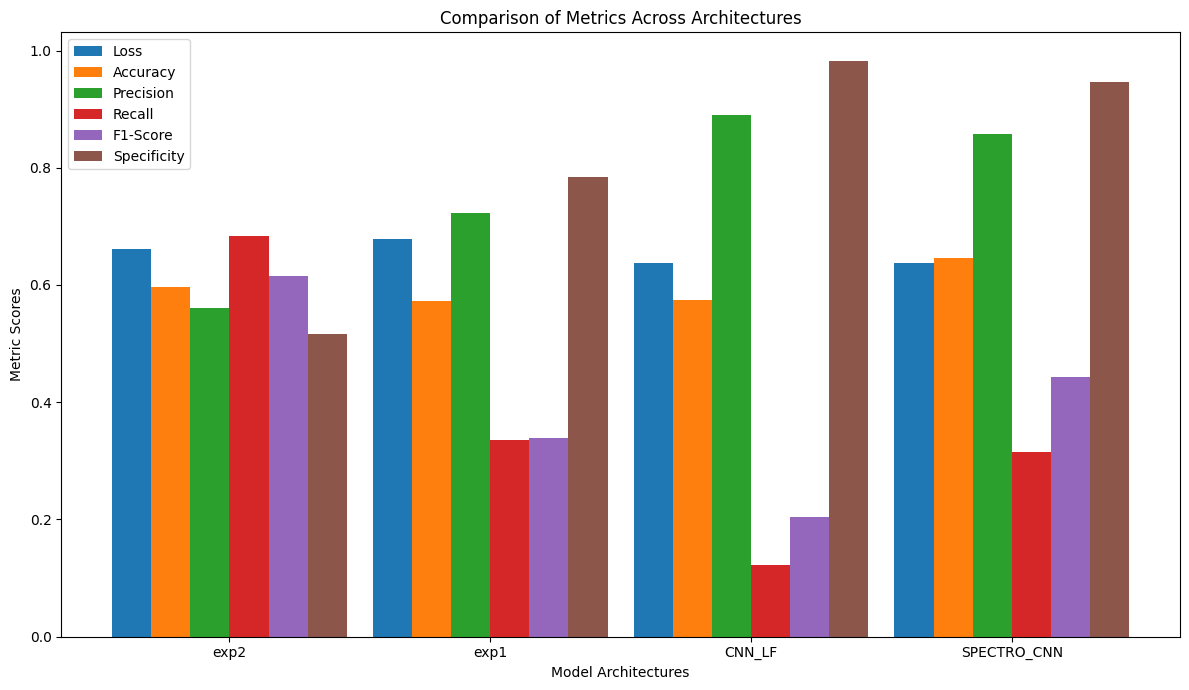

In [19]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, KFold
# Diccionario de arquitecturas
arqs_to_test = {
    "exp2": [
        [7, 0, 0, 0, 3, 0, 0, 0, 7, 0, 0, 0, 4, 1, 0, 0, 7, 0, 0, 0, 7, 0, 0, 0, 1, 0, 0, 0, 7, 0, 0, 0, 7, 0, 0, 0, 4, 1, 0, 0, 7, 0, 0, 0, 7, 0, 0, 0]
    ],
    "exp1": [
        [6, 9, 0, 1, 3, 3, 0, 0, 2, 1, 0, 0, 7, 0, 0, 0, 5, 0, 0, 0, 3, 2, 0, 0, 7, 0, 0, 0, 7, 0, 0, 0, 7, 0, 0, 0, 8, 3, 2, 0, 1, 0, 0, 0, 7, 0, 0, 0]
    ],
    "CNN_LF": [
        [0, 30, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 16, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 5, 0, 0, 0, 4, 256, 0, 0, 3, 1, 0, 0, 4, 1, 2, 0]
    ],
    "SPECTRO_CNN": [
        [1, 0, 0, 0, 0, 16, 0, 1, 1, 0, 0, 0, 0, 8, 0, 1, 1, 0, 0, 0, 5, 0, 0, 0, 4, 32, 1, 0, 4, 1, 2, 0, 7, 0, 0, 0, 7, 0, 0, 0, 7, 0, 0, 0, 7, 0, 0, 0]
    ],
}

# Configuración de parámetros globales
config = Config(epochs=50)
# Cargar y procesar datos de audio
audio_dict, sample_rate = load_audio_data('./SM-27', config.window_size, config.sample_rate)
audio_dict = preprocess_audio(audio_dict, sample_rate)

# División inicial en conjuntos de datos
X, Y = train_test_split_audio(audio_dict)
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Resultados por arquitectura
results = {key: [] for key in arqs_to_test.keys()}

# Configuración de parámetros globales
config = Config(epochs=50)

# Resultados por arquitectura
all_fold_results = []  # Para almacenar resultados de cada fold
results = {key: [] for key in arqs_to_test.keys()}  # Resumen por arquitectura

# Loop para cada arquitectura en el diccionario
for model_name, architectures in arqs_to_test.items():
    print(f"Testing model: {model_name}")
    for arq in tqdm(architectures, desc=f"Testing architectures for {model_name}"):
        # Ajustar la arquitectura
        fixed_arch = fixArch(arq, verbose=True)
        model_dict = decode_model_architecture(fixed_arch)
        
        # Crear el modelo
        model = build_tf_model_from_dict(model_dict, input_shape=(128, 128, 1))
        
        # Aplicar K-Fold
        kfold = KFold(n_splits=config.n_splits, shuffle=True)
        fold_metrics = []
        
        for fold, (train_index, val_index) in enumerate(kfold.split(X_train_val), 1):
            X_train, X_val = X_train_val[train_index], X_train_val[val_index]
            Y_train, Y_val = Y_train_val[train_index], Y_train_val[val_index]
            
            # Compilar y entrenar el modelo
            model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=["accuracy", 'Precision', 'Recall', F1])
            model.fit(X_train, Y_train, epochs=config.epochs, validation_data=(X_val, Y_val), verbose=0)
            
            # Evaluar el modelo
            results_fold = model.evaluate(X_test, Y_test, verbose=0)
            Y_pred = (model.predict(X_test) > 0.5).astype("int32")
            
            # Calcular métricas adicionales
            precision = precision_score(Y_test, Y_pred)
            recall = recall_score(Y_test, Y_pred)
            f1 = f1_score(Y_test, Y_pred)
            specificity = specificity_score(Y_test, Y_pred)
            
            # Guardar resultados de cada fold
            fold_result = {
                "Architecture": model_name,
                "Fold": fold,
                "Loss": results_fold[0],
                "Accuracy": results_fold[1],
                "Precision": precision,
                "Recall": recall,
                "F1-Score": f1,
                "Specificity": specificity
            }
            all_fold_results.append(fold_result)
            fold_metrics.append([results_fold[0], results_fold[1], precision, recall, f1, specificity])
            
            # Mostrar progreso de cada fold
            print(f"Fold {fold} results for {model_name}: Loss={results_fold[0]:.3f}, "
                  f"Accuracy={results_fold[1]:.3f}, Precision={precision:.3f}, "
                  f"Recall={recall:.3f}, F1-Score={f1:.3f}, Specificity={specificity:.3f}")
        
        # Promediar métricas por fold
        avg_metrics = np.mean(fold_metrics, axis=0)
        results[model_name].append(avg_metrics)

# Crear un DataFrame con los resultados de todos los folds
df_results = pd.DataFrame(all_fold_results)

# Ajustar decimales a 3 dígitos (puedes cambiarlo según sea necesario)
df_results = df_results.round(3)

# Guardar el DataFrame en un archivo CSV
df_results.to_csv("./ga_model_comparison_results.csv", index=False)

# Mostrar el resumen por arquitectura
print("\nSummary per architecture:")
for model_name, metrics in results.items():
    avg_metrics = np.mean(metrics, axis=0)
    print(f"{model_name} - Loss: {avg_metrics[0]:.3f}, Accuracy: {avg_metrics[1]:.3f}, "
          f"Precision: {avg_metrics[2]:.3f}, Recall: {avg_metrics[3]:.3f}, "
          f"F1-Score: {avg_metrics[4]:.3f}, Specificity: {avg_metrics[5]:.3f}")

# Crear gráfico de barras
metrics_names = ["Loss", "Accuracy", "Precision", "Recall", "F1-Score", "Specificity"]
x_labels = list(results.keys())
averaged_metrics = np.array([np.mean(metrics, axis=0) for metrics in results.values()])

fig, ax = plt.subplots(figsize=(12, 7))
bar_width = 0.15
x = np.arange(len(x_labels))

for i, metric in enumerate(metrics_names):
    ax.bar(x + i * bar_width, averaged_metrics[:, i], bar_width, label=metric)

ax.set_xlabel("Model Architectures")
ax.set_ylabel("Metric Scores")
ax.set_title("Comparison of Metrics Across Architectures")
ax.set_xticks(x + (bar_width * (len(metrics_names) - 1)) / 2)
ax.set_xticklabels(x_labels)
ax.legend()

plt.tight_layout()
plt.show()

In [21]:
df_results.groupby('Architecture').mean()

,Fold,Loss,Accuracy,Precision,Recall,F1-Score,Specificity
Architecture,,,,,,,
CNN_LF,3.0,0.6364,0.5738,0.8898,0.1224,0.2044,0.9818
SPECTRO_CNN,3.0,0.6382,0.6468,0.8580,0.3144,0.4436,0.9466
exp1,3.0,0.6782,0.5720,0.7220,0.3364,0.3384,0.7850
exp2,3.0,0.6612,0.5956,0.5614,0.6832,0.6160,0.5170


In [46]:
best_model = max(best_models, key=lambda x: x['fitness'])
best_model['fitness']

0.5086797843097632

In [55]:
print(best_model['individual'])

[6, 9, 0, 1, 3, 3, 0, 0, 2, 1, 0, 0, 7, 0, 0, 0, 5, 0, 0, 0, 3, 2, 0, 0, 7, 0, 0, 0, 7, 0, 0, 0, 7, 0, 0, 0, 8, 3, 2, 0, 1, 0, 0, 0, 7, 0, 0, 0]


In [47]:
model_dict = decode_model_architecture(best_model['individual'])
model_dict

{'layers': [{'type': 'Conv2D',
   'filters': 32,
   'strides': 1,
   'activation': 'relu'},
  {'type': 'DepthwiseConv2D',
   'filters': 9,
   'strides': 1,
   'activation': 'leaky_relu'},
  {'type': 'Dropout', 'rate': 0.5},
  {'type': 'MaxPooling', 'strides': 2},
  {'type': 'DontCare'},
  {'type': 'Flatten'},
  {'type': 'Dropout', 'rate': 0.4},
  {'type': 'DontCare'},
  {'type': 'DontCare'},
  {'type': 'DontCare'},
  {'type': 'DontCare'},
  {'type': 'DontCare'},
  {'type': 'DontCare'},
  {'type': 'DontCare'},
  {'type': 'DontCare'},
  {'type': 'DontCare'},
  {'type': 'BatchNorm'},
  {'type': 'DontCare'},
  {'type': 'Flatten'},
  {'type': 'Dense', 'units': 1, 'activation': 'sigmoid'}]}

In [48]:
cnn = build_tf_model_from_dict(model_dict)
cnn


Construyendo el modelo en TensorFlow desde el JSON expandido...


<Sequential name=sequential, built=True>

In [52]:
cnn.save('/drive/MyDrive/NAS/EC_Project/best_model_mu100_gens1000_F0p5_5000mu_autoadapt.h5')

In [53]:
cnn.save('/drive/MyDrive/NAS/EC_Project/best_model_mu100_gens1000_F0p5_5000mu_autoadapt.keras')